In [4]:
####### Libraries ########
import numpy as np
import cv2
import matplotlib.pyplot as plt
import dlib
import pandas as pd

### PartA

In [5]:
# This function get an image and the rect of the image
# and return the start coordinates and the width and height 
def bounding_box_coordinates(image, rect):
	# Extract the starting and ending coordinates of the
	# bounding box
	x1,y1 = rect.left(),rect.top()
	x2,y2 = rect.right(),rect.bottom()
    
	# Verify the bounding box coordinates fall within 
	# dimensions of the image
	x1 = max(0, x1)
	y1 = max(0, y1)
	x2 = min(x2, image.shape[1])
	y2 = min(y2, image.shape[0])
    
	# Compute the width and height of the bounding box
	w = x2 - x1
	h = y2 - y1
    
	# return bounding box coordinates
	return (x1, y1, w, h)


# Define the function that read the images and return the faces
def get_boxes(path):
    image = cv2.imread(path)
    # dlib detector needs a rgb image
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define the detector
    detector = dlib.get_frontal_face_detector()
    # Execute the detector on the image
    rects = detector(rgb_image)

    # Get the bounding boxes coordinates
    boxes = [bounding_box_coordinates(rgb_image, r) for r in rects]
    
    
    return rgb_image, boxes, rects
    
    
    

In [6]:
# This function get faces using 2 last functions
def get_faces(path):
    rgb_image, boxes, rects = get_boxes(path)
    
    faces = []
    # Crop faces from an original image
    for (x1,y1,h,w) in boxes:
        faces.append(rgb_image[y1:y1+h, x1:x1+w])

    return rgb_image, faces, boxes, rects
    

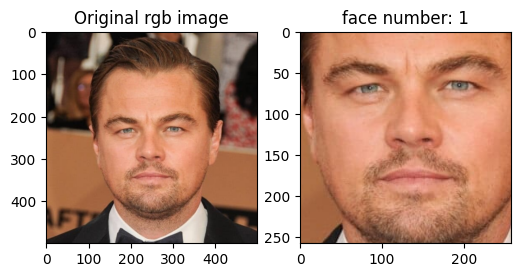

In [7]:
# First image
rgb_image1, faces1, _, rects1 = get_faces("asset/1.png")

# Determine the figure with subplots
coef = len(faces1)+1
fig, axes = plt.subplots(1, coef, figsize=(6,6*coef))
axes = axes.ravel()

axes[0].imshow(rgb_image1)
axes[0].set_title("Original rgb image")

for i in range(1, len(faces1)+1, 1):
    
    # Subplot each contour regarding the n_clusters parameter
    axes[i].imshow(faces1[i-1])
    axes[i].set_title(f"face number: {i}")


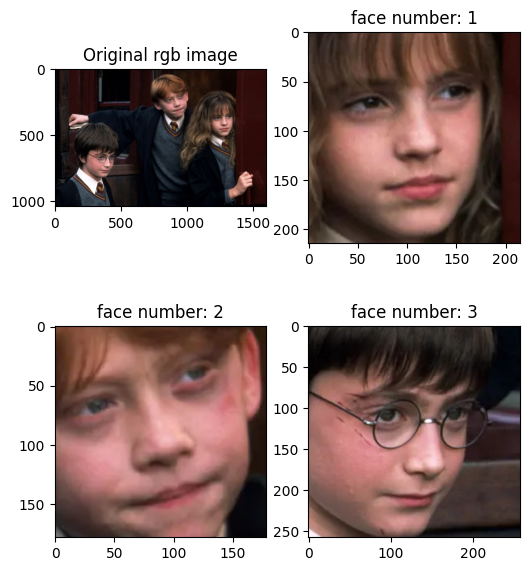

In [8]:
# Second image
rgb_image2, faces2, _, rects2 = get_faces("asset/2.png")

# Determine the figure with subplots
coef = len(faces2)+1
fig, axes = plt.subplots(2, coef//2, figsize=(6,7))
axes = axes.ravel()

axes[0].imshow(rgb_image2)
axes[0].set_title("Original rgb image")

for i in range(1, len(faces2)+1, 1):
    
    # Subplot each contour regarding the n_clusters parameter
    axes[i].imshow(faces2[i-1])
    axes[i].set_title(f"face number: {i}")

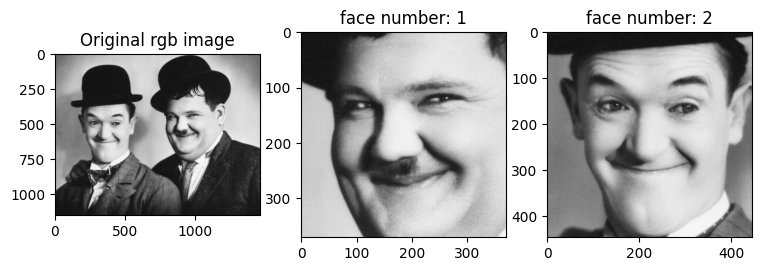

In [9]:
# Third image
rgb_image3, faces3, _, rects3 = get_faces("asset/3.png")

# Determine the figure with subplots
coef = len(faces3)+1
fig, axes = plt.subplots(1, coef, figsize=(9,9*coef))
axes = axes.ravel()

axes[0].imshow(rgb_image3)
axes[0].set_title("Original rgb image")

for i in range(1, len(faces3)+1, 1):
    
    # Subplot each contour regarding the n_clusters parameter
    axes[i].imshow(faces3[i-1])
    axes[i].set_title(f"face number: {i}")

### PartB

In [10]:
# This function extracts keypoints from an image
def get_keypoints(image, rects):
    # Apply shape predictor
    path = 'shape_predictor_68_face_landmarks.dat'
    predictor = dlib.shape_predictor(path)

    # Convert rgb to gray image to obtain the landmarks
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    shapes = []
    for rect in rects:
        shapes.append(predictor(image, rect))

    return shapes



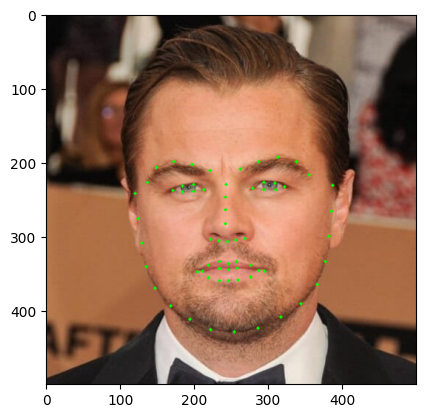

In [11]:
# First image
shapes1 = get_keypoints(rgb_image1, rects1)

# Draw keypoints on the face
copy1 = rgb_image1.copy()
for shape in shapes1:
    for size in shape.parts():
        cv2.circle(copy1, (size.x, size.y), 2, (0, 255, 0), -1)
plt.imshow(copy1)

### PartC

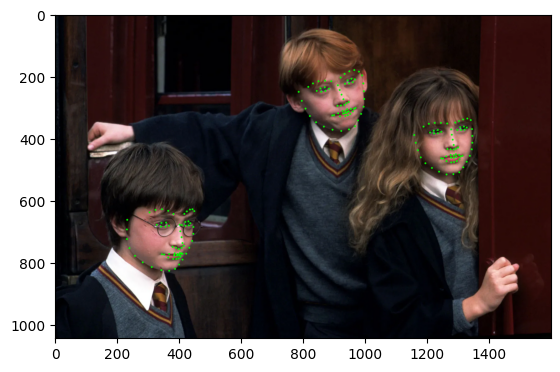

In [12]:
# Second image
shapes2 = get_keypoints(rgb_image2, rects2)

# Draw keypoints on the faces
copy2 = rgb_image2.copy()
for shape in shapes2:
    for size in shape.parts():
        cv2.circle(copy2, (size.x, size.y), 3, (0, 255, 0), -1)
plt.imshow(copy2)

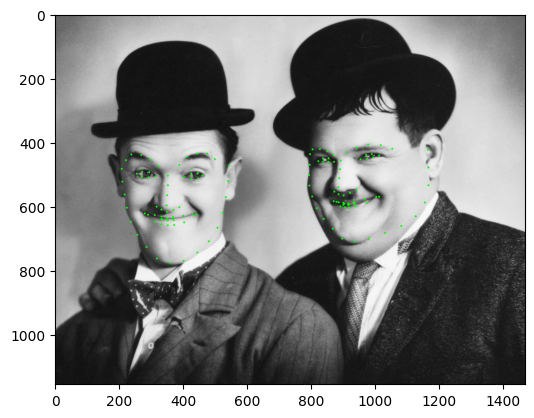

In [13]:
# Third image
shapes3 = get_keypoints(rgb_image3, rects3)

# Draw keypoints on the faces
copy3 = rgb_image3.copy()
for shape in shapes3:
    for size in shape.parts():
        cv2.circle(copy3, (size.x, size.y), 3, (0, 255, 0), -1)
plt.imshow(copy3)

### Part C&D

In [16]:
# This function get keypoints of the face and the joker image,
# find homography matrix and fill the face with the joker image
def get_mask_to_face(faces, rgb_image, joker_image, shapes, src_point,
                    homo_method=0, homo_thresh=None):
    copy_image = rgb_image.copy()
    gray_image = cv2.cvtColor(copy_image, cv2.COLOR_RGB2GRAY)
    
    # Loop on all faces (all keypoints of facesin each image)
    for i,dst_point in enumerate(shapes):
        dst_point = shapes[i]
        # Find homography matrix with default arguments
        H, _ = cv2.findHomography(src_point, dst_point, homo_method,
                                 homo_thresh)

        # Obtain the warped version of the joker_image
        h,w = gray_image.shape
        joker_image_warped = cv2.warpPerspective(joker_image, H, (w, h))

        # Replace the face in the image with the jocker_image
        copy_image = np.where(joker_image_warped != 0, joker_image_warped, copy_image)

    return copy_image
        

joker_image = cv2.imread("asset/joker.png")
df = pd.read_csv("jocker_keypoints/joker.csv")
src_keypoint = np.array([list(row) for row in df.values])

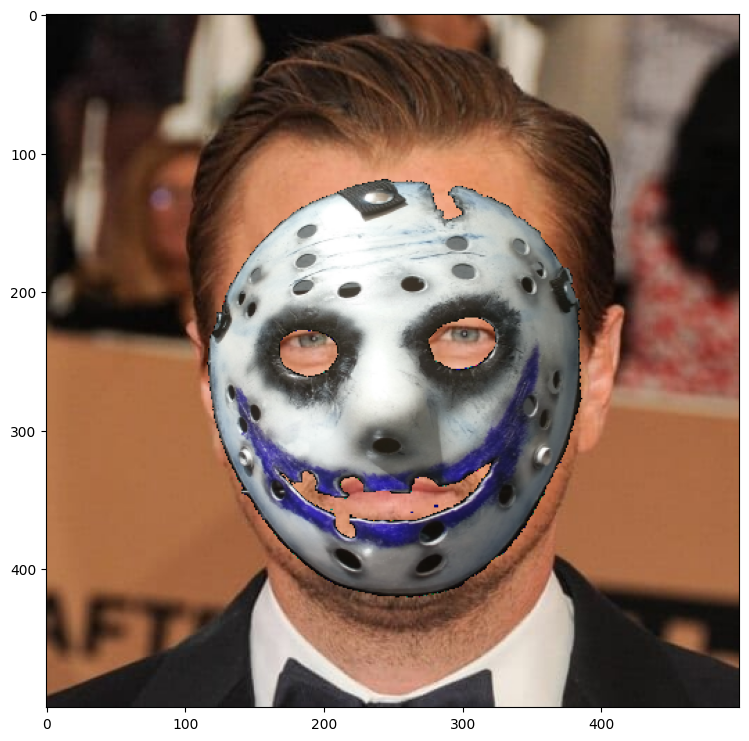

In [17]:
# First image

# Convert the shapes1 object to new_shapes1 to be compatible 
# in findHomography function
new_shapes1 = []

for shape1 in shapes1:
    new_shape1 = [(size.x, size.y) for size in shape1.parts()]
    new_shapes1.append(new_shape1)
    
new_shapes1 = np.array(new_shapes1)
mask_image1 = get_mask_to_face(faces1, rgb_image1, joker_image, 
                               new_shapes1, src_keypoint)

plt.figure(figsize=(9,9))
plt.imshow(mask_image1)

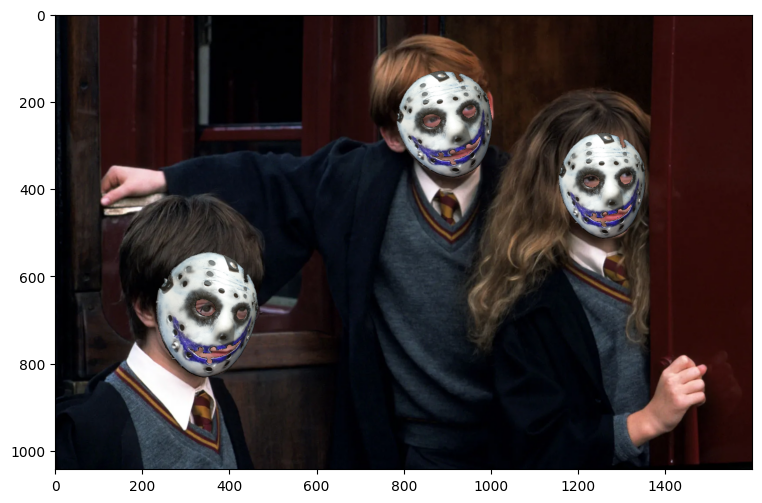

In [18]:
# Second image

# Convert the shapes2 object to new_shapes2 to be compatible 
# in findHomography function
new_shapes2 = []

for shape2 in shapes2:
    new_shape2 = [(size.x, size.y) for size in shape2.parts()]
    new_shapes2.append(new_shape2)
    
new_shapes2 = np.array(new_shapes2)
mask_image2 = get_mask_to_face(faces2, rgb_image2, joker_image, 
                               new_shapes2, src_keypoint)

plt.figure(figsize=(9,9))
plt.imshow(mask_image2)

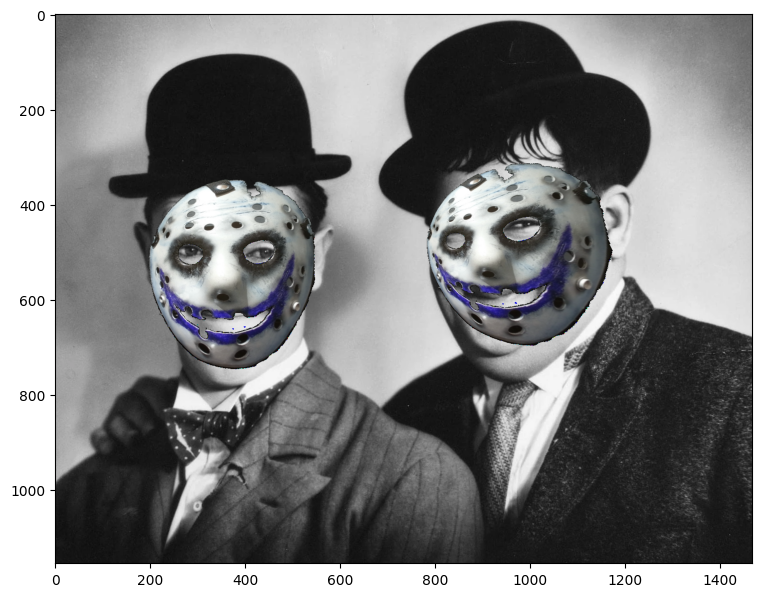

In [19]:
# Third image

# Convert the shapes3 object to new_shapes3 to be compatible 
# in findHomography function
new_shapes3 = []

for shape3 in shapes3:
    new_shape3 = [(size.x, size.y) for size in shape3.parts()]
    new_shapes3.append(new_shape3)
    
new_shapes3 = np.array(new_shapes3)
mask_image3 = get_mask_to_face(faces3, rgb_image3, joker_image, 
                               new_shapes3, src_keypoint)

plt.figure(figsize=(9,9))
plt.imshow(mask_image3)

### Questions

#### Question1

**The SIFT algorithm or other unsupervised detectors as the keypoint detectors are inappropriate as they extract general keypoints in an image, Whereas the significant keypoints of the face like the eyes, nose, mouth are requied. So, by these methods, either abundant keypoints are extracted or essential keypoints are disregarded.**

#### Question2

**The applied mask on the 1.png is shown in the 12th cell**

#### Question3

**The basic mask was applied on the 2.png image and the image was shown in the 13th cell. We saw that for Harry Potter the applied joker mask has some errors, particularly on the right eye of him. By method=cv2.RANSAC and threshold=47, the mask of Harry Potter is improved. The corretced version with refining the arguments of the cv2.findHomography function is shown below**

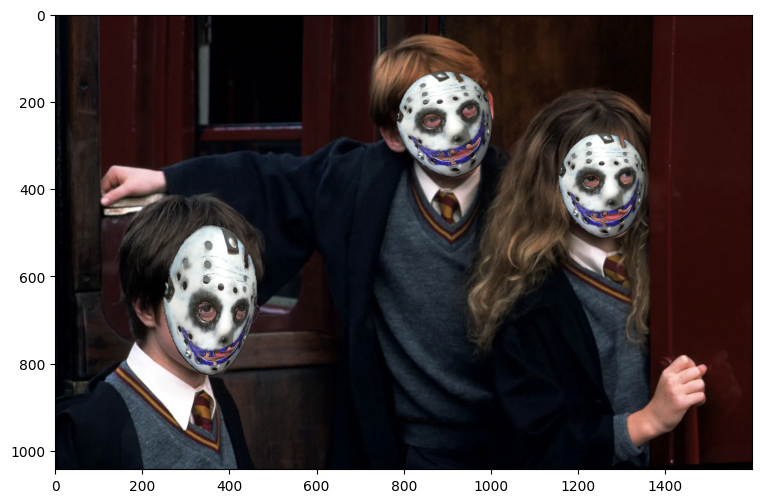

In [20]:
# Modified version of algorithm on the second image

# Convert the shapes2 object to new_shapes2 to be compatible 
# in findHomography function
new_shapes2 = []

for shape2 in shapes2:
    new_shape2 = [(size.x, size.y) for size in shape2.parts()]
    new_shapes2.append(new_shape2)
new_shapes2 = np.array(new_shapes2)

# Use the RANSAC and threshold=47 as the method arguments
mask_image2 = get_mask_to_face(faces2, rgb_image2, joker_image, 
                               new_shapes2, src_keypoint,
                              homo_method= cv2.RANSAC, homo_thresh=47)


plt.figure(figsize=(9,9))
plt.imshow(mask_image2)

#### Question4

**Even by changing the method and threshold parameter, masked faces are not refined completely(Specifically for Hardy).(I chnaged these 2 arguments several times). Solution: It's evident from the keypoints of the third image that the keypoint of the Hardy's face is not precise. So we could either do some preprocessing actions like increase the illuminate or flip the image or create other joker's mask with the keypoint that is compatible with the Hardy's face**

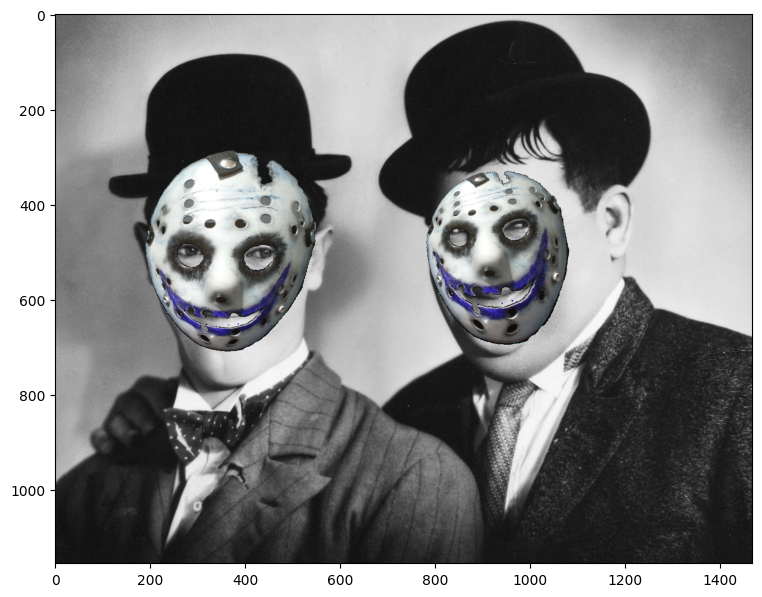

In [21]:
# Modified version of algorithm on the second image
# Convert the shapes2 object to new_shapes2 to be compatible 
# in findHomography function
new_shapes3 = []
for shape3 in shapes3:
    new_shape3 = [(size.x, size.y) for size in shape3.parts()]
    new_shapes3.append(new_shape3)
    
new_shapes3 = np.array(new_shapes3)
mask_image3 = get_mask_to_face(faces3, rgb_image3, joker_image, 
                               new_shapes3, src_keypoint,
                              homo_method= cv2.RANSAC, homo_thresh=40)

plt.figure(figsize=(9,9))
plt.imshow(mask_image3)